In [4]:
"""
https://www.kaggle.com/c/dogs-vs-cats/overview
"""
import os
import shutil
from pathlib import Path

iskaggle = os.getenv("KAGGLE_KERNEL_RUN_TYPE")

# If on kaggle, install packages
if iskaggle:
    os.system("pip install fastai loguru")

from fastai.callback.schedule import fine_tune
from fastai.data.external import URLs, untar_data
from fastai.data.transforms import get_image_files
from fastai.learner import Learner, export, load_learner
from fastai.metrics import error_rate
from fastai.vision.augment import Resize
from fastai.vision.core import PILImage
from fastai.vision.data import ImageDataLoaders
from fastai.vision.learner import vision_learner
from fastai.vision.models import resnet34
from loguru import logger

url = URLs.DOGS
# Download and unpack dataset
path = untar_data(url)

model_file = Path("model.pkl")

In [5]:
# Define label function
def is_cat(image_file_name: str) -> bool:
    return image_file_name.startswith("cat")

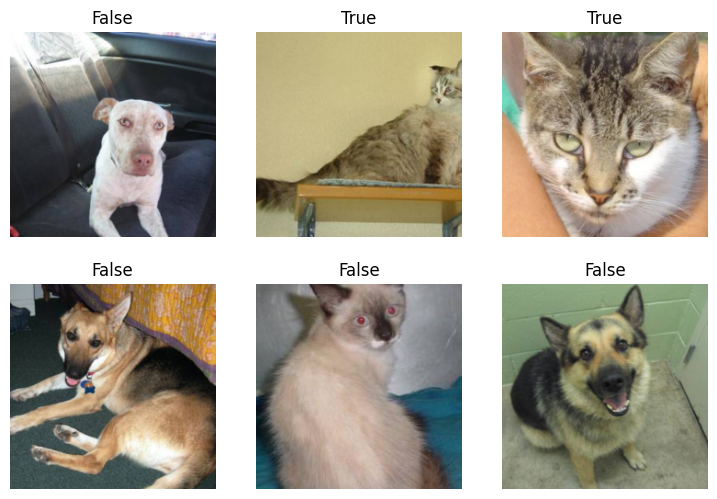

In [6]:
# Define data loader
dls = ImageDataLoaders.from_name_func(
    path,
    get_image_files(path),
    valid_pct=0.2,
    seed=42,
    label_func=is_cat,
    item_tfms=Resize(224),
)

# display examples
dls.show_batch(max_n=6)

In [7]:
# Load model if already trained
learn = None
if model_file.is_file():
    # model_file.unlink()
    logger.info("Model exists, load model")
    learn = load_learner(model_file)
    # learn = load_model(model_file, nn.Sequential, opt=Optimizer)

# Train model if it doesn't exist
if learn is None:
    logger.info("Model does not exist, train model")

    learn = vision_learner(dls, resnet34, metrics=error_rate)
    learn.fine_tune(1)

    logger.info("Done training model")
    # learn.save() and load_model() are only for checkpoints in the training process
    learn.export("model.pkl")
    shutil.copy("/root/.fastai/data/dogscats/model.pkl", model_file)

# If on kaggle, provide download link to model
if iskaggle:
    logger.info("Provide model download link")
    from IPython.display import FileLink

    FileLink(model_file)

2023-12-27 02:35:24.855 | INFO     | __main__:<module>:5 - Model exists, load model


2023-12-27 02:35:24.920 | INFO     | __main__:<module>:2 - Predict an image


2023-12-27 02:35:25.017 | INFO     | __main__:<module>:5 - Result for image /home/burny/.fastai/data/dogscats/test1/3571.jpg is: ('False', tensor(0), tensor([0.9979, 0.0021]))


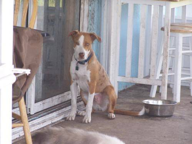

In [8]:
# Predict result from a test image
logger.info("Predict an image")
image = get_image_files(path / "test1")[2]
result = learn.predict(image)
logger.info(f"Result for image {image} is: {result}")
# Show a preview of the image on notebook
PILImage.create(image).to_thumb(192)